In [1]:
from MMT_reduce_module import *

In [2]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()


## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (April 4, 2019): 

* Fix saturated data!
    * Examine how sky frames are being made 
    * Examine how sky subtraction is being performed on science data
    * Determine best practice of aligning saturated frames
    * plt.imshow reduced steps
    * Stacking size issue 
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues? -- **done, 5/23**
    * Double-check dome flat correction, now that twilight flat correction is working (with correct inputs)
    
More to-do items (last updated 5/23):
* Ensure corquad correction is applied prior to analysis steps - **done, 5/23**
* Rotation angle correction and image flip for MMT data (appears to be same VLT conventions) - update within module
* Cross-check sky subtraction in case of very saturated data, and if small changes in rotation angle make difference


In [3]:
cd ../../HIP12097/0.8s/

/Users/u5ajain/Desktop/HIP12097/0.8s


### Set up paths to raw data and definitions

In [4]:
path_to_raw_sci = '/Users/u5ajain/Desktop/HIP12097/0.8s/'
path_to_raw_darks = '/Users/u5ajain/Dropbox (Amherst College)/2016_10_11_run/Calibrations/darks/'
path_to_raw_flats = '/Users/u5ajain/Dropbox (Amherst College)/2016_10_11_run/Calibrations/twilight/'
objname = 'HIP12097_0.8s'
flattype = 0 # 0 for sky, 1 for lamp
saturated = 0 # 0 if unsaturated, 1 if saturated
alignflag = 0 # 0 if single star or faint companion, 1 if equal brightness binary or difficult to align for some reason
imsize = 1024

In [5]:
path_to_raw_darks

'/Users/u5ajain/Dropbox (Amherst College)/2016_10_11_run/Calibrations/darks/'

## The following cells are each of the steps of the reduce_raw_sci function

In [6]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'q*.fits')

print(f"Number of science frames found: {len(scilist)} \n")


Number of science frames found: 37 



In [7]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 0.8



In [8]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

In [9]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0

for ii in range(0, n):
    
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)
    
    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)





In [10]:
print(angle)
print(im)

[-0.86190835 -0.87432595 -0.83202025 -0.87026385 -0.84270795 -0.82733669
 -0.82618739 -0.8416095  -0.86930312 -0.83088501 -0.87344428 -0.86077457
 -0.85547511 -0.84483048 -0.82502189 -0.85969745 -0.8763788  -0.87529444
 -0.85876247 -0.82370883 -0.84372713 -0.84823735 -0.82254046 -0.84715525
 -0.88511742 -0.857735   -0.85656088 -0.87741626 -0.84594406 -0.87240903
 -0.86398442 -0.82958903 -0.84035405 -0.83923627 -0.82843621 -0.86298533
 -0.87129749]
[[ 0.        57.518     52.1227    ... 39.18406   43.168488  48.283512 ]
 [ 2.7276287 51.500576  44.883194  ... 57.193027  53.21463   50.145767 ]
 [ 2.5310514 56.524345  52.030045  ... 50.21515   48.198193  47.13502  ]
 ...
 [ 2.978559  63.143604  48.60304   ... 65.63121   61.56165   70.633026 ]
 [ 3.000433  61.04828   52.569263  ... 65.67657   72.771     67.82197  ]
 [ 3.107144   2.7887628 59.183357  ... 26.865953  39.03852   76.306984 ]]


Creating and applying master darks and flats...

Found 52 darks with exposure times of 0.8. 



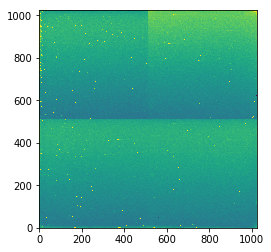

In [11]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax, origin='lower')

In [12]:

# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


Found 51 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 



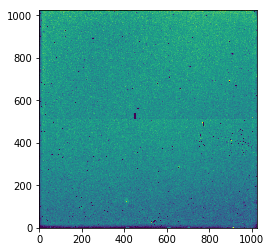

In [13]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax, origin='lower')

In [14]:
# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat



Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



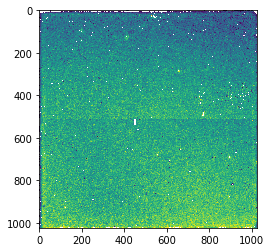

In [15]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax)

In [16]:

# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)

# print(reduced_sciarray)

Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20
Correcting image #21
Correcting image #22
Correcting image #23
Correcting image #24
Correcting image #25
Correcting image #26
Correcting image #27
Correcting image #28
Correcting image #29
Correcting image #30
Correcting image #31
Correcting image #32
Correcting image #33
Correcting image #34
Correcting image #35
Correcting image #36


In [17]:
# write out a test reduced science image 
fits.writeto('test_reduced_science.fits', reduced_sciarray[:,:,0], overwrite=True)

In [18]:
#MASTER_SKY
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



4.022159302394368


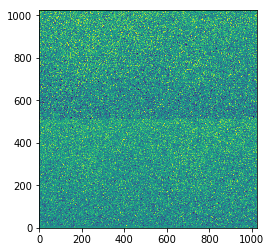

In [19]:
# get median and examine sky output:
print(np.median(sky_output[1]))
vmin, vmax = interval.get_limits(sky_output[1])
plt.imshow(sky_output[1], vmin=vmin, vmax=vmax, origin='lower')

In [20]:
sky_output

(0, array([[2.60276133, 2.86899146, 2.98221456, ..., 2.96103086, 2.96103086,
         2.83122778],
        [2.92248217, 2.88845824, 3.12957473, ..., 3.00607547, 3.04379519,
         4.01525781],
        [3.33335191, 3.29913429, 3.38559394, ..., 3.89738943, 3.84234834,
         3.94297586],
        ...,
        [4.34337601, 4.47970528, 4.89146911, ..., 5.3857437 , 5.89560629,
         4.55760319],
        [3.82311415, 4.50404508, 8.06110257, ..., 2.19271209, 4.56279481,
         4.56279481],
        [3.9133249 , 4.3861892 , 5.04876654, ..., 6.24893205, 4.40281713,
         4.55825088]]))

In [21]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [22]:
rot_flag

0

In [23]:
#INDIVIDUAL_REDUCED_SCI_IMAGES
t0=time.time()

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
    
t1=time.time()
print("Time taken: ", (t1-t0)/60.)

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4
Saving reduced frame #5
Saving reduced frame #6
Saving reduced frame #7
Saving reduced frame #8
Saving reduced frame #9
Saving reduced frame #10
Saving reduced frame #11
Saving reduced frame #12
Saving reduced frame #13
Saving reduced frame #14
Saving reduced frame #15
Saving reduced frame #16
Saving reduced frame #17
Saving reduced frame #18
Saving reduced frame #19
Saving reduced frame #20
Saving reduced frame #21
Saving reduced frame #22
Saving reduced frame #23
Saving reduced frame #24
Saving reduced frame #25
Saving reduced frame #26
Saving reduced frame #27
Saving reduced frame #28
Saving reduced frame #29
Saving reduced frame #30
Saving reduced frame #31
Saving reduced frame #32
Saving reduced frame #33
Saving reduced frame #34
Saving reduced frame #35
Saving reduced frame #36
Time taken:  0.06142346461613973


In [ ]:
idl = pidly.IDL('/Applications/exelis/idl85/bin/idl')

In [ ]:
idl('ds9')

In [ ]:
!echo $IDL_PATH

In [25]:
# get current directory where reduced frames are written
current_dir = os.getcwd()

# measure star positions in all of the images
xcen, ycen = measure_star_centers(skysub_science_array, scinames_list, sciheader, saturated, 0, current_dir, saveframes = True)


% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: ARRAY_INDICES.
% Compiled module: GCNTRD.
Overwriting existing science frames with star position values: reducedsci_000.fits
Overwriting existing science frames with star position values: reducedsci_001.fits
Overwriting existing science frames with star position values: reducedsci_002.fits
Overwriting existing science frames with star position values: reducedsci_003.fits
Overwriting existing science frames with star position values: reducedsci_004.fits
Overwriting existing science frames with star position values: reducedsci_005.fits
Overwriting existing science frames with star position values: reducedsci_006.fits
Overwriting existing science frames with star position values: reducedsci_007.fits
Overwriting existing science frames with star position values: reducedsci_008

In [26]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [257.34851074 175.04534912 792.93481445 162.87771606 761.12438965
 691.18365479 739.13861084 712.78753662 114.20912933 744.79095459
 218.20874023 203.76596069 145.02964783 678.1350708  688.4822998
 246.29811096 277.30673218 229.46516418 291.84622192 638.07232666
 719.62695312 817.0949707  595.05596924 779.27490234 217.68251038
 233.34347534 191.81552124 316.64886475 739.45330811 263.2399292
 343.5944519  703.63397217 663.83795166 624.01696777 647.92529297
 303.46447754 204.74124146] ycen: [890.60968018 359.22564697 262.75524902 262.65966797 702.92224121
 276.34185791 218.10440063 660.91436768 315.52093506 323.17623901
 304.40197754 859.55908203 806.28503418 816.73236084 168.65658569
 800.34869385 339.51644897 401.2230835  734.21075439 227.56524658
 760.94091797 755.63256836 284.19467163 807.28729248 303.04977417
 699.41693115 755.73468018 291.8269043  868.98651123 244.83287048
 777.93322754 377.72314453 722.55145264 769.58825684 332.30429077
 835.73815918 197.51425171]


In [27]:
#SHIFTED_IMAGES
#STACKED
#FINAL
t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")

2301 2292
Shifting image 0 of 37...
Shifting image 1 of 37...
Shifting image 2 of 37...
Shifting image 3 of 37...
Shifting image 4 of 37...
Shifting image 5 of 37...
Shifting image 6 of 37...
Shifting image 7 of 37...
Shifting image 8 of 37...
Shifting image 9 of 37...
Shifting image 10 of 37...
Shifting image 11 of 37...
Shifting image 12 of 37...
Shifting image 13 of 37...
Shifting image 14 of 37...
Shifting image 15 of 37...
Shifting image 16 of 37...
Shifting image 17 of 37...
Shifting image 18 of 37...
Shifting image 19 of 37...
Shifting image 20 of 37...
Shifting image 21 of 37...
Shifting image 22 of 37...
Shifting image 23 of 37...
Shifting image 24 of 37...
Shifting image 25 of 37...
Shifting image 26 of 37...
Shifting image 27 of 37...
Shifting image 28 of 37...
Shifting image 29 of 37...
Shifting image 30 of 37...
Shifting image 31 of 37...
Shifting image 32 of 37...
Shifting image 33 of 37...
Shifting image 34 of 37...
Shifting image 35 of 37...
Shifting image 36 of 37...
%








## everything below is random testing

In [ ]:
reduced_array = glob.glob('reduced*')

for ii in reduced_array:
    reducedsci = fits.getdata(ii)
    reducedsci_header = fits.getheader(ii)
    
    xcen = reducedsci_header['CRPIX1A']
    ycen = reducedsci_header['CRPIX2A']
    
    vmin1, vmax1 = interval.get_limits(reducedsci)
    plt.imshow(reducedsci, vmin=vmin1, vmax=vmax1)
    plt.plot(xcen, ycen, marker = 'o', markersize = 10)
    plt.show()



In [ ]:
n = len(scinames_list)

xcen = np.zeros(n)
ycen = np.zeros(n)

idl = pidly.IDL('/Applications/exelis/idl/bin/idl')
idl_changedir = 'cd, ' + f'"{current_dir}"'
idl(idl_changedir)

for ii in range(0, 1):
    # idl('name = "'+sciname+'"')
    idl('name = "'+ scinames_list[ii] +'"')
    idl('im=MRDFITS(name,0,/FSCALE,/SILENT)')
    idl('tmp=SMOOTH(im,21,/EDGE_TRUNCATE)')
    idl('tmp[0:100,*]=0.0')
    idl('tmp[924:1023,*]=0.0')
    idl('tmp[*,0:100]=0.0')
    idl('tmp[*,1000:1023]=0.0')
    idl('foo=MAX(tmp,ind,/NAN)')
    idl('ind=ARRAY_INDICES(tmp,ind)')
    idl('print, foo')
    
    if saturated == 0:
        idl('GCNTRD,im[ind[0]-20:ind[0]+20,ind[1]-20:ind[1]+20],20,20,xcen,ycen,3.0')
        idl('xcen += ind[0]-20.0')
        idl('ycen += ind[1]-20.0')
        xcen[ii], ycen[ii] = idl.xcen, idl.ycen
    else:
        idl('x=ind[0]')
        idl('y=ind[1]')
        idl('sim = im[x-20:x+20,y-20:y+20]')
        idl('weights = (sim*0.0)+1.0')
        idl('weights[WHERE(sim ge 0.7*MAX(sim,/NAN))]=0.0')
        idl('fit=MPFIT2DPEAK(sim,A,WEIGHTS=weights)')
        idl('xcen = A[4]+(x-20.0)')
        idl('ycen = A[5]+(y-20.0)')
        xcen[ii], ycen[ii] = idl.xcen, idl.ycen
        idl('print, A[5]')

print(xcen[ii],ycen[ii])

In [ ]:
idl.A

In [ ]:
reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, imsize = 1024)
